# Postprocessing a FNN Trained for a Mass-Spring-Damper System 

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from tensorflow                           import keras

import romnet                             as rmnt

In [2]:
### Defining ODE and its Parameters

from scipy.integrate import solve_ivp

def fOrig(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Source(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

Params = np.array([1.0, 0.5, 3.0], dtype=np.float64)

In [3]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'
PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN/Deterministic/Run_9/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN/MCDropOut/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN/BayesByBackprop/Run_2/'

TrainingCases = [0]#[0,2,4,6,8]
TestCases     = [0,2,4]#[0,2]

NSamples      = 100

Nt            = 100
tout          = np.linspace(0.,15.,Nt)
SOLVER        = 'Radau'

LineTypeVec   = ['-',':','--','.-']*10

In [4]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH, ROMNetFldr)


InputData.InputFilePath = PathToRunFld+'/ROMNet_Input.py'
InputData.TrainIntFlg   = 0
InputData.PathToRunFld  = PathToRunFld


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE//ROMNet/MSD_10Cases/FNN/Deterministic/Run_9/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


In [5]:
SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

Net   = getattr(rmnt.nn, SurrogateType)

model = rmnt.model.Model_Deterministic(InputData)

model.build(InputData, None, Net)

NN    = model.net


[ROMNet]:   Initializing the ML Model

[ROMNet]:   Building the ML Model

[ROMNet]:   Loading ML Model Parameters from File:  /Users/sventuri/WORKSPACE//ROMNet/MSD_10Cases/FNN/Deterministic/Run_9//Training/Params//000539.h5
'load_params' took 0.031054 s


[ROMNet]:   Saving ML Model Parameters to File:  /Users/sventuri/WORKSPACE//ROMNet/MSD_10Cases/FNN/Deterministic/Run_9//Model/Params/Initial.h5
'save_params' took 0.031239 s

'build' took 0.767177 s



iVar =  1
u0 =  [-1.07856426 -0.82275602]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [-0.44206703 -0.41951141]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [ 0.51190231 -0.21291579]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


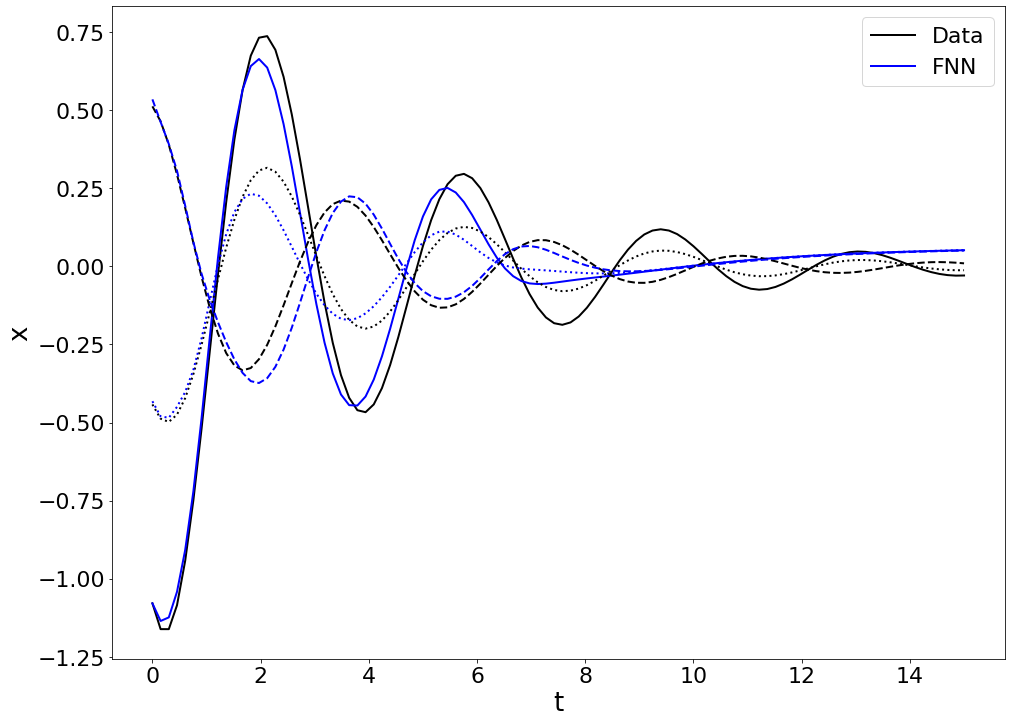

In [6]:
### Evaluating on Test Data

FileName  = InputData.PathToDataFld + '/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[InputData.OutputVars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T


## Variable to Be Visualized
VarOI     = 'x'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break

iSim = 0
for iTest in TestCases:
    
    print('u0 = ', u[iTest,:])

    ### Generating Data  
    output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    tOrig      = tout
    yMatOrig   = output.y.T
    
    ### Creating NN Input
    tPred     = tOrig[...,np.newaxis]
    Nt        = len(tPred)
    uPred     = u[iTest,:]*np.ones((Nt,2))
    InputPred = np.concatenate((tPred,uPred), axis=1)
    
    if (InputData.ProbApproach == 'Deterministic') or (NSamples == 1):
        
        yMat = NN.predict(InputPred)    
        
        ## Plotting
        
        if (iSim == 0):
            fig    = plt.figure(figsize=(16, 12))
            Label1 = 'Data'
            Label2 = 'FNN'
        else:
            Label1 = None
            Label2 = None
    
        plt.plot(tOrig, yMatOrig[:,iVar-1],  'k'+LineTypeVec[iSim], label=Label1)
        plt.plot(tPred, yMat[:,iVar-1],      'b'+LineTypeVec[iSim], label=Label2)
        plt.xlabel('t')
        plt.ylabel(VarOI)
        plt.legend()
        #plt.show()
        
    else:

        ### Sampling NN
        yMat_sum = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))
        yMat_sqr = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))

        for iSample in range(NSamples):
            yMat_ = NN.predict(InputPred)    
            yMat_sum += yMat_
            yMat_sqr += yMat_**2

        yMat_mean = yMat_sum/NSamples
        yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
        yMat_p1   = yMat_mean + 1.*yMat_std
        yMat_m1   = yMat_mean - 1.*yMat_std
        yMat_p2   = yMat_mean + 2.*yMat_std
        yMat_m2   = yMat_mean - 2.*yMat_std
        yMat_p3   = yMat_mean + 3.*yMat_std
        yMat_m3   = yMat_mean - 3.*yMat_std


        ## Plotting
        fig = plt.figure(figsize=(16, 12))
        plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label='Data')
        plt.plot(tPred, yMat_mean[:,iVar-1], 'b-', label=r'FNN, $\mu$')
        plt.plot(tPred, yMat_p3[:,iVar-1],   'b:', label=r'FNN, $\mu+3\sigma$')
        plt.plot(tPred, yMat_m3[:,iVar-1],   'b:', label=r'FNN, $\mu-3\sigma$')
        plt.xlabel('t')
        plt.ylabel(VarOI)
        plt.legend()
        plt.show()
        
    iSim += 1

In [7]:
Input   = {}
Weights = {}
for data_id in InputData.NTrain.keys():
    FileName         = InputData.PathToDataFld + '/train/'+data_id+'/Input.csv'
    Data             = pd.read_csv(FileName)
    Input[data_id]   = Data
    
    FileName         = InputData.PathToRunFld + '/Training/LossWeights/'+data_id+'_300.csv'
    Data             = pd.read_csv(FileName, header=None)
    Weights[data_id] = Data

Text(0.5, 0, 'v')

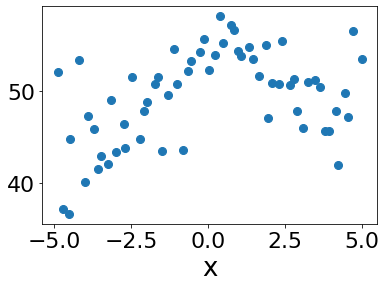

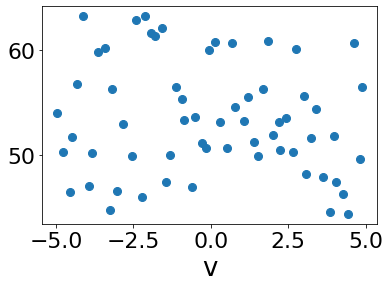

In [8]:
#%matplotlib qt

data_id = 'ics'

# fig = plt.figure()
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(Input[data_id]['x'], Input[data_id]['v'], Weights[data_id][1])
# ax.set_xlabel('x')
# ax.set_ylabel('y')

fig = plt.figure()
plt.scatter(Input[data_id]['x'], Weights[data_id][0])
plt.xlabel('x')

fig = plt.figure()
plt.scatter(Input[data_id]['v'], Weights[data_id][1])
plt.xlabel('v')

In [9]:
%matplotlib qt

data_id = 'res'

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(Input[data_id]['t'], Input[data_id]['x'], Weights[data_id][1])
ax.set_xlabel('t')
ax.set_ylabel('x')

# fig = plt.figure()
# plt.scatter(Input[data_id]['t'], Weights[data_id][0])
# plt.xlabel('t')

# fig = plt.figure()
# plt.scatter(Input[data_id]['t'], Weights[data_id][1])
# plt.xlabel('t')

Text(0.5, 0, 'x')